<a href="https://colab.research.google.com/github/davidyxwu/word-embeddings/blob/main/word_embeddings_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install torchdata

import torch
import sys
import random
from torchtext.datasets import IMDB, CoLA
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe, FastText, vocab
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
import numpy as np
import gc

import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/




Set Seed

In [ ]:
SEED = 0
torch.manual_seed(SEED)

Fix Model & Dataset Parameters for all experiments

For Experiment run:

emb_size = 300

hid_size = 200

out_size = 2

n_layers = 2

dropout_rate = 0.5

lr = 10e-4

IMDB_batch_size = 32

cola_batch_size = 4

epochs = 20

In [ ]:
emb_size = 300
hid_size = 200
out_size = 2
n_layers = 2
dropout_rate = 0.5
lr = 5e-4

IMDB_batch_size = 32
cola_batch_size = 4

epochs = 10

LSTM Model:

In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, emb_size, hid_size, out_size, n_layers, dropout_rate, pad_index, pretrained_vec=None, freeze=True):
        super(LSTM, self).__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.hid_size = hid_size
        self.out_size = out_size
        self.dropout_rate = dropout_rate
        """
        Layers
        """
        # Check for pretrained vectors and freezing
        if pretrained_vec is not None:
          self.emb = nn.Embedding.from_pretrained(pretrained_vec, freeze=freeze, padding_idx=pad_index)
        else:
          self.emb = nn.Embedding(self.vocab_size, self.emb_size, padding_idx=pad_index)
        self.dropout = nn.Dropout(p=self.dropout_rate)
        self.lstm = nn.LSTM(self.emb_size, self.hid_size, n_layers, dropout=self.dropout_rate, batch_first=True)
        self.fc = nn.Linear(self.hid_size, self.out_size)

    def forward(self, inputs, lengths):
        embeddings = self.emb(inputs)
        packed_embedding = pack_padded_sequence(embeddings, lengths.to('cpu'), batch_first=True, enforce_sorted=False)
        lstm_out, (hidden, cell) = self.lstm(packed_embedding)
        output, output_len = pad_packed_sequence(lstm_out)
        hidden = self.dropout(hidden[-1])
        out = self.dropout(hidden)
        out = self.fc(out)
        return out

Download vectors (TAKES A LONG TIME!!!!) 

---



In [ ]:
fasttext = FastText('en')
#glove = GloVe('6B', dim=300)

Download dataset and split into train valid test



In [ ]:
#IMDB_train, IMDB_test = IMDB(split=('train', 'test'))
cola_train, cola_valid, cola_test = CoLA(split=('train', 'dev', 'test'))
#IMDB_test, IMDB_valid = IMDB_train.random_split(total_length=len(list(IMDB_test)), weights={"test": 0.8, "valid": 0.2}, seed=torch.initial_seed())
def print_split(dataset, train, valid, test):
  print(f"{dataset} Splits: Train size: {len(list(train))} Valid Size: {len(list(valid))} Test Size: {len(list(test))}")

#print_split("IMDB", IMDB_train, IMDB_valid, IMDB_test)
print_split("CoLA", cola_train, cola_valid, cola_test)

CoLA Splits: Train size: 8550 Valid Size: 526 Test Size: 515


Tokenizer (spacy)

In [ ]:
tokenizer = get_tokenizer(tokenizer='spacy', language='en_core_web_sm')
def yield_tokens(data_iter, text_index):
    for d in data_iter:
        yield tokenizer(d[text_index])

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Build vocabs for untrained and pretrained (Long Time!!!)

In [ ]:
def build_vocab(train_set, text_index):
  specials=['<PAD>', '<UNK>', '<BOS>', '<EOS>']
  built_vocab = {"untrained": build_vocab_from_iterator(
      yield_tokens(train_set, text_index), specials=specials, min_freq=10), 
      #"glove": vocab(glove.stoi), 
      "fasttext": vocab(fasttext.stoi)
      }
  """
  for i in range(len(specials)):
    built_vocab["glove"].insert_token(specials[i], i)
    built_vocab["fasttext"].insert_token(specials[i], i)
  """
    
  built_vocab["untrained"].set_default_index(built_vocab["untrained"]['<UNK>'])
  #built_vocab["glove"].set_default_index(built_vocab["glove"]['<UNK>'])
  #built_vocab["fasttext"].set_default_index(built_vocab["fasttext"]['<UNK>'])
  return built_vocab

Build Vocabs for datasets (vocab will only be different for the untrained model)


In [ ]:
#IMDB_vocab = build_vocab(IMDB_train, 1)
cola_vocab = build_vocab(cola_train, 2)

Build Batches

Standardize labels to 0: Negative/unacceptable, 1: Positive/acceptable

In [ ]:
IMDB_label_map = {1: 0, 2: 1}
cola_label_map = {0: 0, 1: 1}

In [ ]:
def build_batches(vocab, batch_size, train, valid, test, label_map, label_index, text_index):
    text_transform = lambda x: [vocab['<BOS>']] + [vocab[token] for token in tokenizer(x)] + [vocab['<EOS>']]

    train_list  = list(train)
    valid_list = list(valid)
    test_list = list(test)

    """
    Helper functions to generate batches
    """
    def collate_batch(batch):
        label_list, text_list, lengths = [], [], []
        for b in batch: 
          label_list.append(label_map[b[label_index]])
          processed_text = text_transform(b[text_index])
          text_list.append(torch.tensor(processed_text))
          lengths.append(len(processed_text))
        padded_text = pad_sequence(text_list, padding_value=vocab['<PAD>'], batch_first=True)
        return torch.tensor(label_list), padded_text, torch.tensor(lengths) 

    def batch_sampler(data_list):
        indices = [(i, len(tokenizer(s[text_index]))) for i, s in enumerate(data_list)]
        random.Random(SEED).shuffle(indices)
        pooled_indices = []
        # create pool of indices with similar lengths
        for i in range(0, len(indices), batch_size * 100):
            pooled_indices.extend(sorted(indices[i:i + batch_size * 100], key=lambda x: x[1]))

        pooled_indices = [x[0] for x in pooled_indices]

        # yield indices for current batch
        for i in range(0, len(pooled_indices), batch_size):
            yield pooled_indices[i:i + batch_size]

    train_iterator = DataLoader(train_list, batch_sampler=batch_sampler(train_list),
                                collate_fn=collate_batch)
    valid_iterator = DataLoader(valid_list, batch_sampler=batch_sampler(valid_list),
                                collate_fn=collate_batch)
    test_iterator = DataLoader(test_list, batch_sampler=batch_sampler(test_list),
                                collate_fn=collate_batch)
    return {"train": list(train_iterator), "valid": list(valid_iterator), "test": list(test_iterator)}

Fetch batches

In [ ]:
#IMDB_untrained_batches = build_batches(IMDB_vocab["untrained"], IMDB_batch_size, IMDB_train, IMDB_valid, IMDB_test, IMDB_label_map, 0, 1)
#IMDB_glove_batches = build_batches(IMDB_vocab["glove"], IMDB_batch_size, IMDB_train, IMDB_valid, IMDB_test)
#IMDB_fasttext_batches = build_batches(IMDB_vocab["fasttext"], IMDB_batch_size, IMDB_train, IMDB_valid, IMDB_test)

cola_untrained_batches = build_batches(cola_vocab["untrained"], cola_batch_size, cola_train, cola_valid, cola_test, cola_label_map, 1, 2)

Prepare Vectors by adding special token vectors

In [ ]:
#glove_vectors = torch.cat((torch.zeros(3, glove.vectors.shape[1]), glove.vectors))
#fasttext_vectors = torch.cat((torch.zeros(3, fasttext.vectors.shape[1]), fasttext.vectors))

Init models

In [ ]:
#IMDB_untrained_model = LSTM(len(IMDB_vocab["untrained"]), emb_size, hid_size, out_size, n_layers, dropout_rate, IMDB_vocab["untrained"]["<PAD>"])
cola_untrained_model = LSTM(len(cola_vocab["untrained"]), emb_size, hid_size, out_size, n_layers, dropout_rate, cola_vocab["untrained"]["<PAD>"])
#glove_model = LSTM(len(IMDB_vocab["glove"]), emb_size, hid_size, out_size, n_layers, dropout_rate, IMDB_vocab["glove"]["<PAD>"], pretrained_vec=glove_vectors, freeze=False)
#glove_model_frozen = LSTM(len(IMDB_vocab["glove"]), emb_size, hid_size, out_size, n_layers, dropout_rate, IMDB_vocab["glove"]["<PAD>"], pretrained_vec=glove_vectors, freeze=True)
#fasttext_model = LSTM(len(IMDB_vocab["fasttext"]), emb_size, hid_size, out_size, n_layers, dropout_rate, IMDB_vocab["fasttext"]["<PAD>"], pretrained_vec=fasttext_vectors)

Print Model Details

In [ ]:
def print_model_details(name, model):
  print(f"{name} model details")
  trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print(model)
  print(f"This model has {trainable_params} trainable parameters")

In [ ]:
#print_model_details("IMDB untrained model", IMDB_untrained_model)
print_model_details("CoLA untrained model", cola_untrained_model)


CoLA untrained model model details
LSTM(
  (emb): Embedding(931, 300, padding_idx=0)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 200, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=200, out_features=2, bias=True)
)
This model has 1002902 trainable parameters


In [ ]:
# Adam optimizer
#IMDB_untrained_optimizer = optim.Adam(IMDB_untrained_model.parameters(), lr=lr)
cola_untrained_optimizer = optim.Adam(cola_untrained_model.parameters(), lr=lr)

#glove_optimizer = optim.Adam(glove_model.parameters(), lr=lr)
#glove_frozen_optimizer = optim.Adam(glove_model_frozen.parameters(), lr=lr)
#fasttext_optimizer = optim.Adam(fasttext_model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#IMDB_untrained_model = IMDB_untrained_model.to(device)
cola_untrained_model = cola_untrained_model.to(device)

#glove_model = glove_model.to(device)
#glove_model_frozen = glove_model_frozen.to(device)
#fasttext_model = fasttext_model.to(device)

criterion = criterion.to(device)

Setup Experiments

In [ ]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [ ]:
def train(dataloader, model, criterion, optimizer, device):

    model.train()
    epoch_losses = []
    epoch_accs = []

    for idx, (label, text, lengths) in tqdm.tqdm(enumerate(dataloader), desc='training...', file=sys.stdout):
        inputs = text.to(device)
        labels = label.to(device)
        prediction = model(inputs, lengths)
        loss = criterion(prediction, labels)
        accuracy = get_accuracy(prediction, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [ ]:
def evaluate(dataloader, model, criterion, device):
    
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for idx, (label, text, lengths) in tqdm.tqdm(enumerate(dataloader), desc='evaluating...', file=sys.stdout):
            inputs = text.to(device)
            labels = label.to(device)
            prediction = model(inputs, lengths)            
            loss = criterion(prediction, labels)
            accuracy = get_accuracy(prediction, labels)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

Returning loss/acc per step

In [ ]:
def run_epochs(epochs, model, optimizer, criterion, device, train_set, valid_set, name="Model", filename="model.pt"):
  print(name)
  print('─' * 20)
  
  best_valid_loss = float('inf')
  train_losses = []
  train_accs = []
  valid_losses = []
  valid_accs = []

  epoch_train_losses = []
  epoch_train_accs = []
  epoch_valid_losses = []
  epoch_valid_accs = []

  for epoch in range(epochs):
    train_loss, train_acc = train(train_set, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_set, model, criterion, device)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)

    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)

    epoch_train_losses.append(epoch_train_loss)
    epoch_train_accs.append(epoch_train_acc)
    epoch_valid_losses.append(epoch_valid_loss)
    epoch_valid_accs.append(epoch_valid_acc)

    if epoch_valid_loss < best_valid_loss:
      best_valid_loss = epoch_valid_loss
      torch.save(model.state_dict(), filename)
    
    print(f'Epoch: {epoch + 1}')
    print(f'Train Loss: {epoch_train_loss:.3f}, Train Acc: {epoch_train_acc:.3f}')
    print(f'Valid Loss: {epoch_valid_loss:.3f}, Valid Acc: {epoch_valid_acc:.3f}\n')
  return {"train_losses": train_losses, "train_accs": train_accs, "valid_losses": valid_losses, "valid_accs": valid_accs,
          "epoch_train_losses": epoch_train_losses, "epoch_train_accs": epoch_train_accs, "epoch_valid_losses": epoch_valid_losses, "epoch_valid_accs": epoch_valid_accs}

Experiment!

In [ ]:
#IMDB_untrained_stats = run_epochs(epochs, IMDB_untrained_model, IMDB_untrained_optimizer, criterion, device, IMDB_untrained_batches["train"], IMDB_untrained_batches["valid"], "UNTRAINED IMDB MODEL", "IMDB_untrained_model.pt")

In [ ]:
cola_untrained_stats = run_epochs(epochs, cola_untrained_model, cola_untrained_optimizer, criterion, device, cola_untrained_batches["train"], cola_untrained_batches["valid"], "UNTRAINED COLA MODEL", "cola_untrained_model.pt")

UNTRAINED COLA MODEL
────────────────────
training...: 2138it [01:01, 34.73it/s]
evaluating...: 132it [00:00, 232.05it/s]
Train Loss: 0.552, Train Acc: 0.737
Valid Loss: 0.629, Valid Acc: 0.674

training...: 2138it [01:10, 30.18it/s]
evaluating...: 132it [00:00, 224.71it/s]
Train Loss: 0.499, Train Acc: 0.766
Valid Loss: 0.650, Valid Acc: 0.676



In [ ]:
print(cola_untrained_stats["epoch_train_accs"], cola_untrained_stats["epoch_train_losses"])
print(cola_untrained_stats["epoch_valid_accs"], cola_untrained_stats["epoch_valid_losses"])

[0.7371375116931712, 0.7663704396632367] [0.5521027746464852, 0.4988251667943678]
[0.6742424242424242, 0.6761363636363636] [0.6288332871415399, 0.6503873447125609]


TEST

In [ ]:
def test(model, test_set, criterion, device, name="Model", filename="model.pt"):
  model.load_state_dict(torch.load(filename))
  model.eval()

  epoch_predictions = []
  epoch_true_labels = []
  epoch_losses = []
  epoch_accs = []

  with torch.no_grad():
      for idx, (label, text, lengths) in tqdm.tqdm(enumerate(test_set), desc='evaluating...', file=sys.stdout):
          inputs = text.to(device)
          labels = label.to(device)
          prediction = model(inputs, lengths)            
          loss = criterion(prediction, labels)

          epoch_true_labels.extend(labels.cpu().numpy())
          epoch_predictions.extend(prediction.cpu().argmax(dim=-1).numpy())

          accuracy = get_accuracy(prediction, labels)
          epoch_losses.append(loss.item())
          epoch_accs.append(accuracy.item())

  total_test_loss, total_test_acc = np.mean(epoch_losses), np.mean(epoch_accs)
  print(f"Model: {name}, Test Loss: {total_test_loss:.3f}, Test Acc: {total_test_acc:.3f}")
  return epoch_predictions, epoch_true_labels

In [ ]:
#IMDB_untrained_predictions, IMDB_true = test(IMDB_untrained_model, IMDB_untrained_batches["test"], criterion, device, "UNTRAINED IMDB MODEL", "IMDB_untrained_model.pt")

In [ ]:
cola_untrained_predictions, cola_untrained_true = test(cola_untrained_model, cola_untrained_batches["test"], criterion, device, "UNTRAINED COLA MODEL", "cola_untrained_model.pt")

evaluating...: 129it [00:00, 193.42it/s]
Model: UNTRAINED COLA MODEL, Test Loss: 0.627, Test Acc: 0.676


VISUALIZATON

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno
import itertools
from sklearn.metrics import confusion_matrix, classification_report

Functions to plot


In [ ]:
# Plot training and validation data
def plot(train, valid, train_label, valid_label, x_label, y_label, title, epochs):
  fig = plt.figure(figsize=(10, 6))
  ax = fig.add_subplot(1, 1, 1)
  ax.title.set_text(title)
  ax.plot(range(1, epochs + 1), train, label=train_label, marker='o')
  ax.plot(range(1, epochs + 1), valid, label=valid_label, marker='o')
  ax.set_xticks(range(1, epochs + 1))
  plt.legend()
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Plots

Epoch Accuraccy

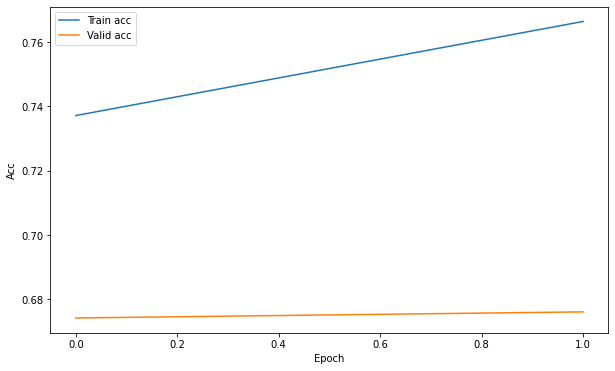

In [ ]:
plot(cola_untrained_stats["epoch_train_accs"], cola_untrained_stats["epoch_valid_accs"], "Train acc", "Valid acc", "Epoch", "Acc", "Title", epochs)

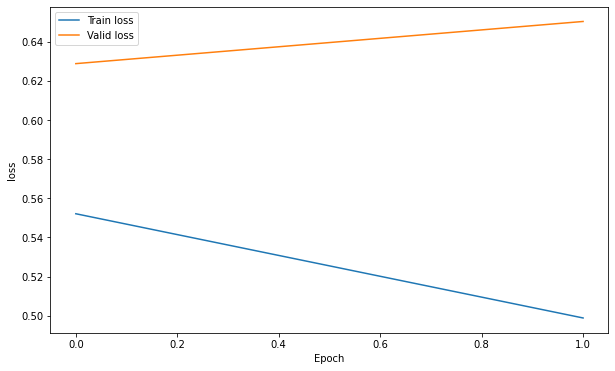

In [ ]:
plot(cola_untrained_stats["epoch_train_losses"], cola_untrained_stats["epoch_valid_losses"], "Train loss", "Valid loss", "Epoch", "loss", "Title", epochs)

Confusion Matrix

For CoLA, labels are Not Acceptable and Acceptable

For IMDB, labels are Negative and Positive

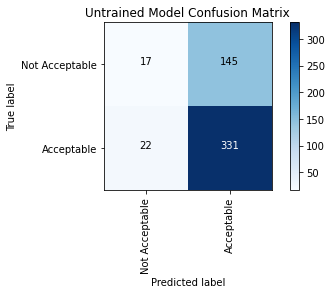

In [ ]:
untrained_cola_confusion_matrix = confusion_matrix(cola_untrained_true, cola_untrained_predictions)
plot_confusion_matrix(untrained_cola_confusion_matrix, classes=['Not Acceptable', 'Acceptable'], title='Untrained Model Confusion Matrix')

Print Final Metrics

In [ ]:
def print_model_metrics(model_name, true, predicted, target_names=None):
  print(f"{model_name} metrics:")
  print(classification_report(true, predicted, target_names=target_names))

In [ ]:
print_model_metrics("Untrained CoLA Model", cola_untrained_true, cola_untrained_predictions, target_names=['Not Acceptable', 'Acceptable'])

Untrained CoLA Model metrics:
                precision    recall  f1-score   support

Not Acceptable       0.44      0.10      0.17       162
    Acceptable       0.70      0.94      0.80       353

      accuracy                           0.68       515
     macro avg       0.57      0.52      0.48       515
  weighted avg       0.61      0.68      0.60       515

